In [4]:
import numpy as np
import pandas as pd
from IPython.display import clear_output as cls
import json
from PIL import Image
import tensorflow as tf

# Data Visualization
import matplotlib.pyplot as plt

# Model
import keras
from tensorflow.keras import layers
import os

In [5]:
# Image Size
IMG_WIDTH = 512
IMG_HEIGHT = 64
IMAGE_SIZE = (IMG_WIDTH, IMG_HEIGHT)

# Batch Size
BATCH_SIZE = 16

# EPOCHS
EPOCHS = 100

# Model Name
MODEL_NAME = 'info-OCR'


# Learning Rate
LEARNING_RATE = 1e-3

# Random Seed
np.random.seed(2569)
tf.random.set_seed(2569)

# File Paths
train_image_dir = './Datasets/CleanData/Images'
train_labels_file = './Datasets/CleanData/labels.json'

# AUTOTUNE
AUTOTUNE = tf.data.AUTOTUNE

In [6]:
with open(train_labels_file, 'r', encoding="utf-8") as f:
    dict_labels = json.load(f)

In [7]:
train_labels = [str(word) for word in dict_labels.values()]
train_labels[:10]

['LỚP : 18DCLC1',
 'Ngành học: Giáo dục Tiểu học',
 'Khóa: 2022',
 'Ngày sinh   : 28/05/1999',
 'Họ và tên: NGUYỄN THẾ ANH',
 'THẺ SINH VIÊN',
 'THẺ SINH VIEN',
 'SINH VIEN',
 'Lớp: Quản trị và phân tích dữ liệu - K4',
 'Ngành: Ngôn ngữ Anh']

In [8]:
unique_chars = list(set(char for word in train_labels for char in word))
unique_chars.sort()
n_classes = len(unique_chars)

# Show
print(f"Total number of unique characters : {n_classes}")
print(f"Unique Characters : \n{unique_chars}")

Total number of unique characters : 176
Unique Characters : 
[' ', '!', '&', '(', ')', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'X', 'Y', '`', 'a', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'x', 'y', 'À', 'Á', 'Â', 'Ã', 'Ê', 'Ì', 'Í', 'Ò', 'Ó', 'Ô', 'Õ', 'Ù', 'Ú', 'Ý', 'à', 'á', 'â', 'ã', 'é', 'ê', 'ì', 'í', 'ò', 'ó', 'ô', 'õ', 'ù', 'ú', 'ý', 'Ă', 'ă', 'Đ', 'đ', 'Ĩ', 'ĩ', 'Ũ', 'ũ', 'Ơ', 'ơ', 'Ư', 'ư', 'Ạ', 'ạ', 'Ả', 'ả', 'Ấ', 'ấ', 'Ầ', 'ầ', 'Ẩ', 'ẩ', 'Ậ', 'ậ', 'Ắ', 'ắ', 'Ằ', 'Ẳ', 'Ẵ', 'Ặ', 'Ẻ', 'ẻ', 'Ế', 'ế', 'Ề', 'ề', 'ể', 'Ễ', 'ễ', 'Ệ', 'ệ', 'Ỉ', 'ỉ', 'Ị', 'ị', 'Ọ', 'ọ', 'Ỏ', 'Ố', 'ố', 'Ồ', 'ồ', 'Ổ', 'ổ', 'Ỗ', 'Ộ', 'ộ', 'Ớ', 'ớ', 'Ờ', 'ờ', 'Ở', 'Ợ', 'ợ', 'Ụ', 'ụ', 'Ủ', 'ủ', 'Ứ', 'ứ', 'ừ', 'Ử', 'ử', 'Ữ', 'ữ', 'Ự', 'ự', 'Ỳ', 'ỳ', 'Ỹ', 'ỹ']


In [9]:
MAX_LABEL_LENGTH = max(map(len, train_labels))
print(f"Maximum length of a label : {MAX_LABEL_LENGTH}")

Maximum length of a label : 74


In [10]:
mapping_label = {}
for k, v in dict_labels.items():
    if os.path.exists(f"{train_image_dir}/{k}"):
        mapping_label[f"{train_image_dir}/{k}"] = v

In [11]:
len(mapping_label), len(dict_labels)

(1588, 1588)

In [12]:
char_to_num = layers.StringLookup(
    vocabulary = list(unique_chars),
    mask_token = None
)

num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [13]:
def load_image(image_path : str):

    image = tf.io.read_file(image_path)

    decoded_image = tf.image.decode_jpeg(contents = image, channels = 1)

    cnvt_image = tf.image.convert_image_dtype(image = decoded_image, dtype = tf.float32)
    resized_image = tf.image.resize(images = cnvt_image, size = (IMG_HEIGHT, IMG_WIDTH))
    image = tf.transpose(resized_image, perm = [1, 0, 2])
    image = tf.cast(image, dtype = tf.float32)

    return image

In [14]:
def encode_single_sample(image_path : str, label : str):

    image = load_image(image_path)
    chars = tf.strings.unicode_split(label, input_encoding='UTF-8')

    vecs = char_to_num(chars)

    pad_size = MAX_LABEL_LENGTH - tf.shape(vecs)[0]
    vecs = tf.pad(vecs, paddings = [[0, pad_size]], constant_values=n_classes+1)

    return {'image':image, 'label':vecs}

In [15]:
dataset = tf.data.Dataset.from_tensor_slices((np.array(list(mapping_label.keys())), np.array(list(mapping_label.values()))))
ds_size = len(dataset)
train_size = int(ds_size*0.8)
val_size = int(ds_size*0.1)
test_size = ds_size - train_size - val_size
print(train_size, val_size, test_size)
print(ds_size)

1270 158 160
1588


In [16]:
train_ds = dataset.take(train_size)
val_ds = dataset.skip(train_size).take(val_size)
test_ds = dataset.skip(train_size).skip(val_size).take(test_size)

print(len(train_ds),len(val_ds), len(test_ds))
print(len(dataset))

1270 158 160
1588


In [17]:
train_ds = train_ds.shuffle(1000).map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
val_ds = val_ds.map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)
test_ds = test_ds.map(encode_single_sample, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(AUTOTUNE)

In [18]:
print(f"Training Data Size   : {tf.data.Dataset.cardinality(train_ds).numpy() * BATCH_SIZE}")
print(f"Validation Data Size : {tf.data.Dataset.cardinality(val_ds).numpy() * BATCH_SIZE}")
print(f"Testing Data Size    : {tf.data.Dataset.cardinality(test_ds).numpy() * BATCH_SIZE}")

Training Data Size   : 1280
Validation Data Size : 160
Testing Data Size    : 160


In [19]:
def show_images(data, gird=(4,4), figsize=(10, 2), cmap='binary_r', model=None, decode_pred=None):

    # Plotting configurations
    n_rows, n_cols = gird
    plt.figure(figsize=(figsize[0]*n_cols, figsize[1]*n_rows))

    # Loading Data
    data = next(iter(data))
    images, labels = data['image'], data['label']

    # Iterate over the data
    for index, (image, label) in enumerate(zip(images, labels)):

        # Label processing
        text_label = num_to_char(label)
        text_label = tf.strings.reduce_join(text_label).numpy().decode('UTF-8')
        text_label = text_label.replace("[UNK]", " ").strip()

        # Create a sub plot
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(tf.transpose(image, perm=[1,0,2]), cmap=cmap)
        print(image.shape)
        if model is not None and decode_pred is not None:
            # Make prediction
            pred = model.predict(tf.expand_dims(image, axis=0))
            pred = decode_pred(pred)[0]
            title = f"True : {text_label}\nPred : {pred}"
            plt.title(title)
        else:
            # add title
            plt.title(text_label)

    # Show the final plot
    cls()
    plt.show()

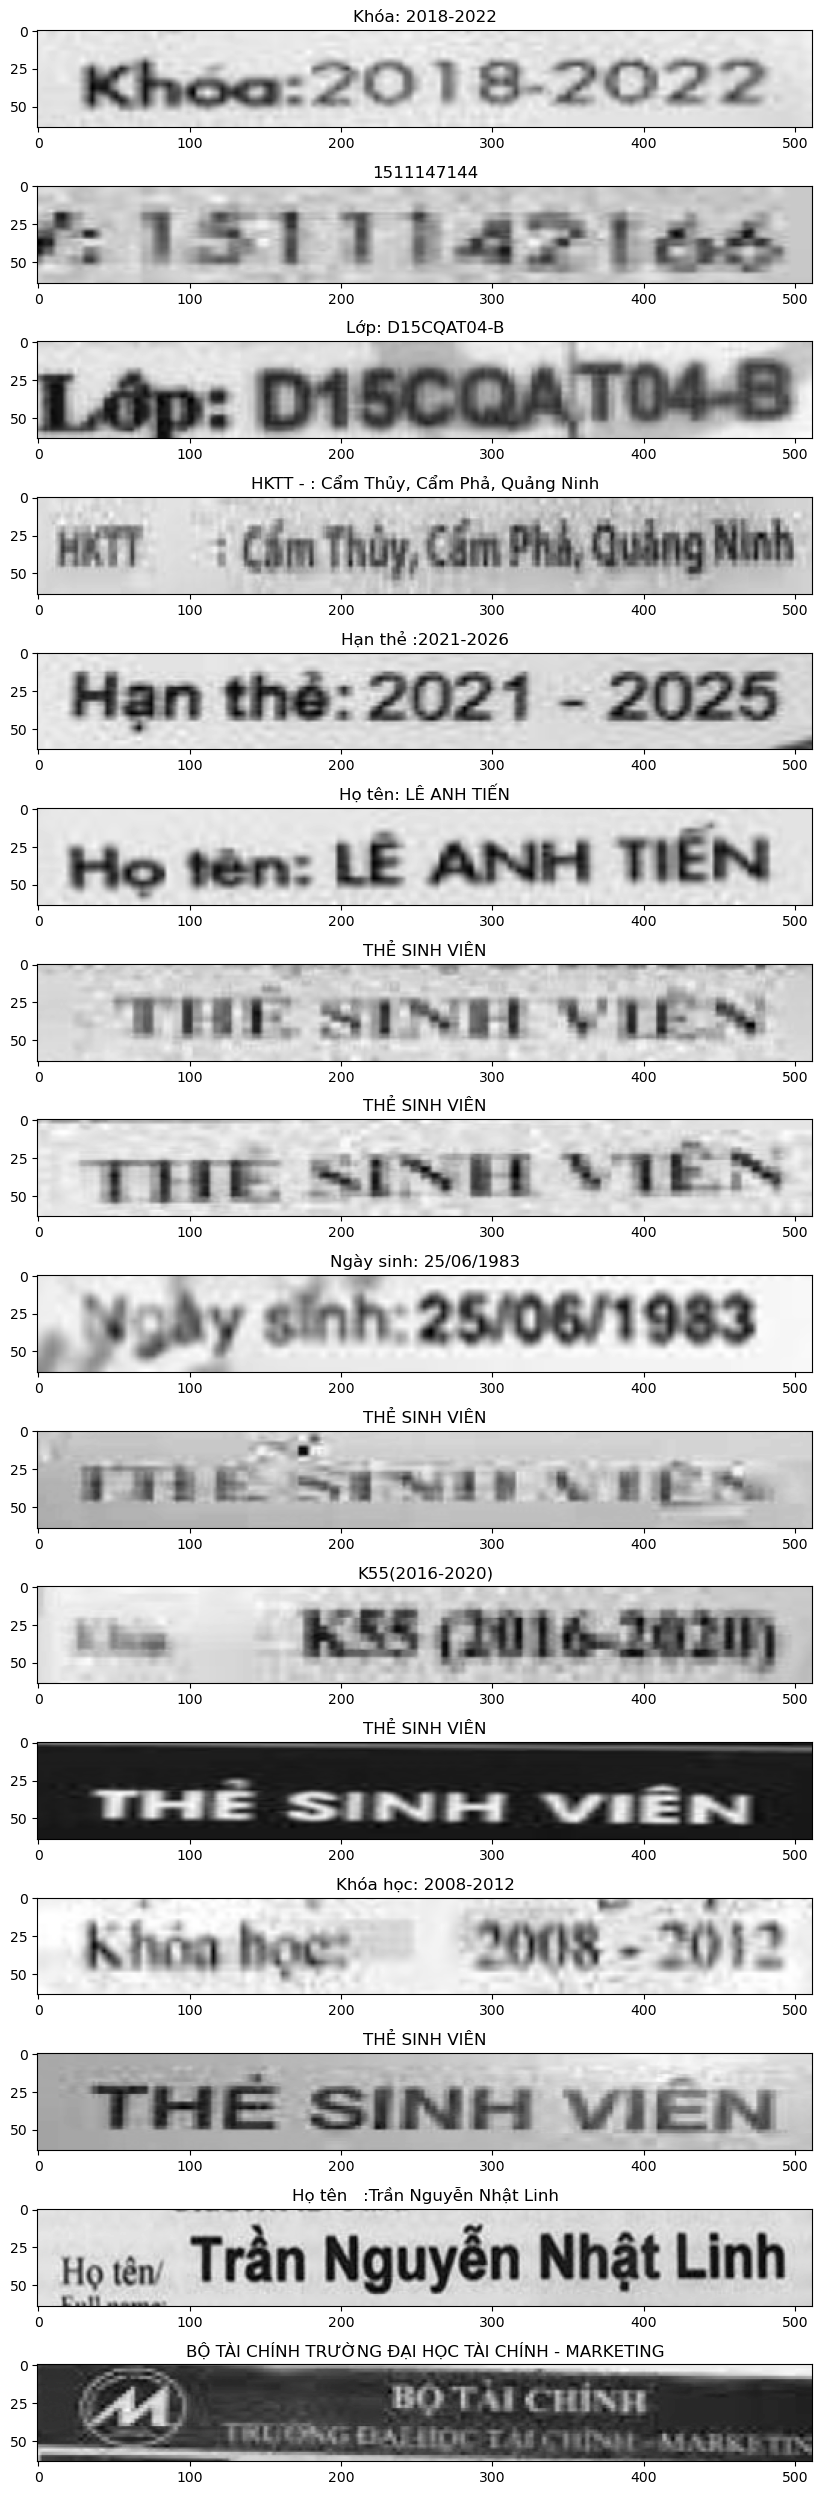

In [20]:
show_images(data=train_ds, cmap='gray', gird=(16, 1))

In [21]:
class CTCLayer(layers.Layer):

    def __init__(self, **kwargs) -> None:
        super().__init__(**kwargs)

        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):

        batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')

        input_len = tf.cast(tf.shape(y_pred)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')
        label_len = tf.cast(tf.shape(y_true)[1], dtype='int64') * tf.ones(shape=(batch_len, 1), dtype='int64')

        loss = self.loss_fn(y_true, y_pred, input_len, label_len)

        self.add_loss(loss)

        return y_pred

In [22]:
def decode_pred(pred_label):

    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]

    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=False, beam_width=10)[0][0][:,:MAX_LABEL_LENGTH]

    chars = num_to_char(decode)

    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]

    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]

    return filtered_texts

In [ ]:
input_images = layers.Input(shape=(IMG_WIDTH, IMG_HEIGHT, 1), name="image")

target_labels = layers.Input(shape=(None, ), name="label")

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    kernel_initializer='he_normal',
    name="block_1"
)(input_images)

x = layers.Conv2D(
    filters=32,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal',
    name="block_2"
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name="pool_1")(x)

x = layers.Conv2D(
    filters=64,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal',
    name="block_3"
)(x)

x = layers.Conv2D(
    filters=128,
    kernel_size=3,
    strides=1,
    padding='same',
    activation='relu',
    kernel_initializer='he_normal',
    name="block_4"
)(x)

x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), name="pool_2")(x)

encoding = layers.Reshape(target_shape=((IMG_WIDTH//4), (IMG_HEIGHT//4)*128))(x)
encoding = layers.Dense(64, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dense(128, activation='relu', kernel_initializer='he_normal')(encoding)
encoding = layers.Dropout(0.4)(encoding)

x = layers.Bidirectional(layers.LSTM(256, return_sequences=True, dropout=0.25))(encoding)
x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)

output = layers.Dense(len(char_to_num.get_vocabulary())+1, activation='softmax', name="output")(x)

ctc_layer = CTCLayer()(target_labels, output)

ocr_model = keras.Model(
    inputs=[input_images, target_labels],
    outputs=[ctc_layer]
)
ocr_model.summary()

In [ ]:
ocr_model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))

In [23]:
history = ocr_model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=2,
)


Epoch 1/2
80/80 ━━━━━━━━━━━━━━━━━━━━ 214s 3s/step - loss: 3619.6978 - val_loss: 1235.2626
Epoch 2/2
34/80 ━━━━━━━━━━━━━━━━━━━━ 1:46 2s/step - loss: 1245.1156

KeyboardInterrupt: 

In [23]:

# Learning Curve
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.legend(fontsize=15)
plt.xlabel("Epochs")
plt.ylabel("CTC Loss Score")
plt.title("Learning Curve", fontsize=15)
plt.grid()
# plt.savefig("OCRModel-LearningCurve.png")
plt.show()

NameError: name 'history' is not defined

In [2]:
ocr_model.load_weights("ocr_model.h5")

NameError: name 'ocr_model' is not defined

In [23]:
# Model required for inference
inference_ocr_model = keras.Model(
    inputs=ocr_model.inputs[0],
    outputs=ocr_model.layers[-2].output
)

inference_ocr_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ image (InputLayer)              │ (None, 512, 64, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_1 (Conv2D)                │ (None, 512, 64, 32)    │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_2 (Conv2D)                │ (None, 512, 64, 32)    │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 256, 32, 32)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_3 (Conv2D)                │ (None, 256, 32, 64)    │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block_4 (Conv2D)                │ (None, 256, 32, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 128, 16, 128)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape (Reshape)               │ (None, 128, 2048)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128, 64)        │       131,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128, 128)       │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128, 512)       │       788,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128, 256)       │       656,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 128, 178)       │        45,746 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,731,986 (6.61 MB)

 Trainable params: 1,731,986 (6.61 MB)

 Non-trainable params: 0 (0.00 B)

In [23]:
inference_ocr_model = keras.models.load_model("../server/model/ocr_model.h5")

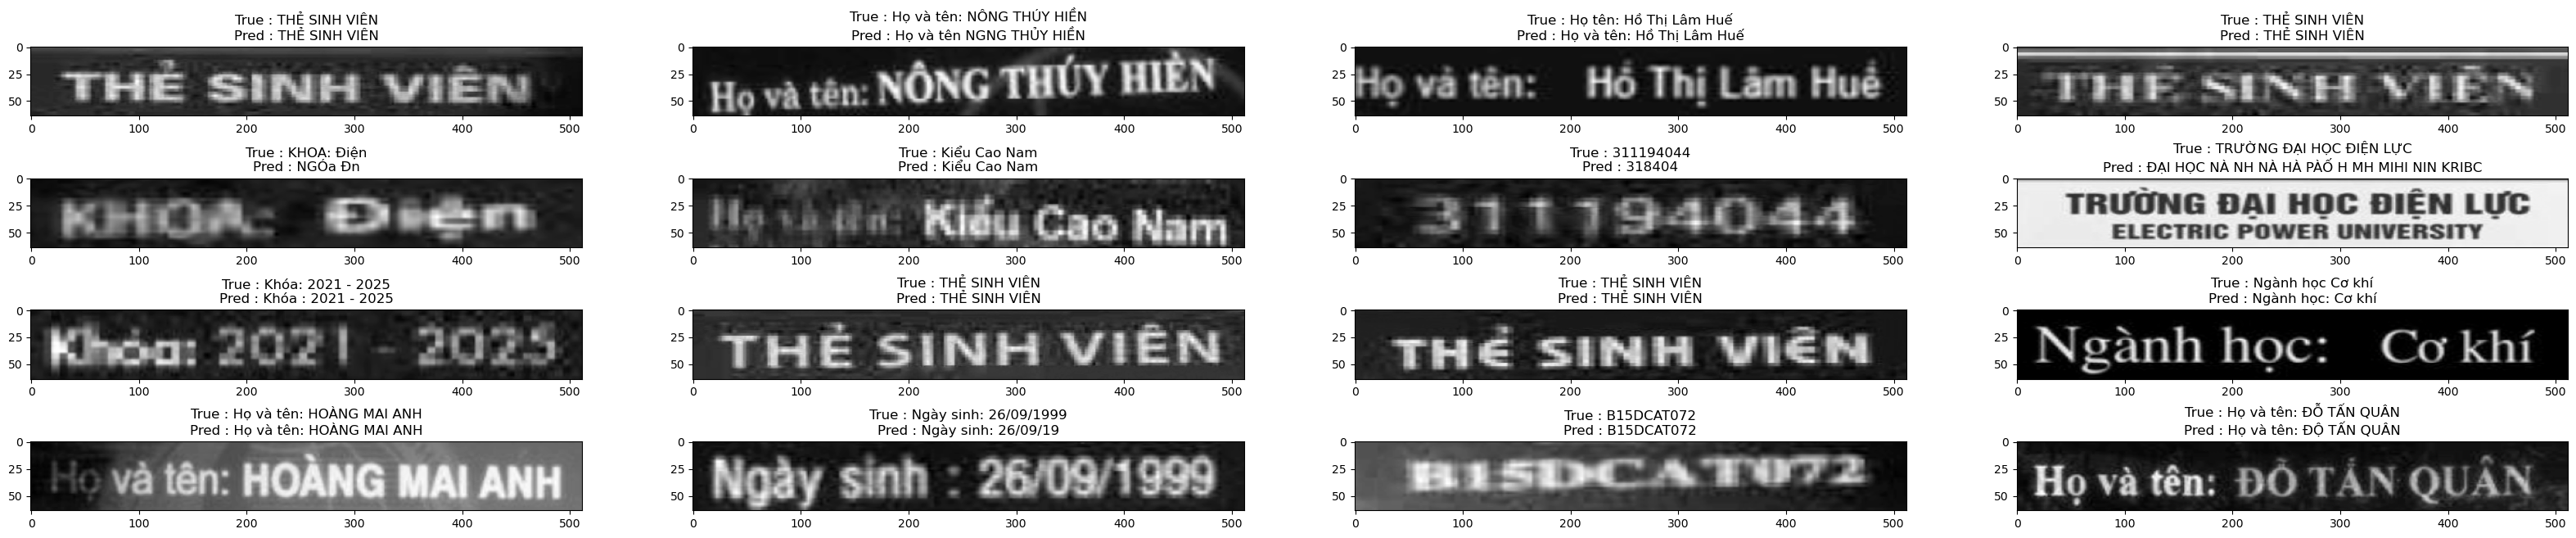

In [24]:
show_images(data=test_ds, model=inference_ocr_model, decode_pred=decode_pred, cmap='binary')

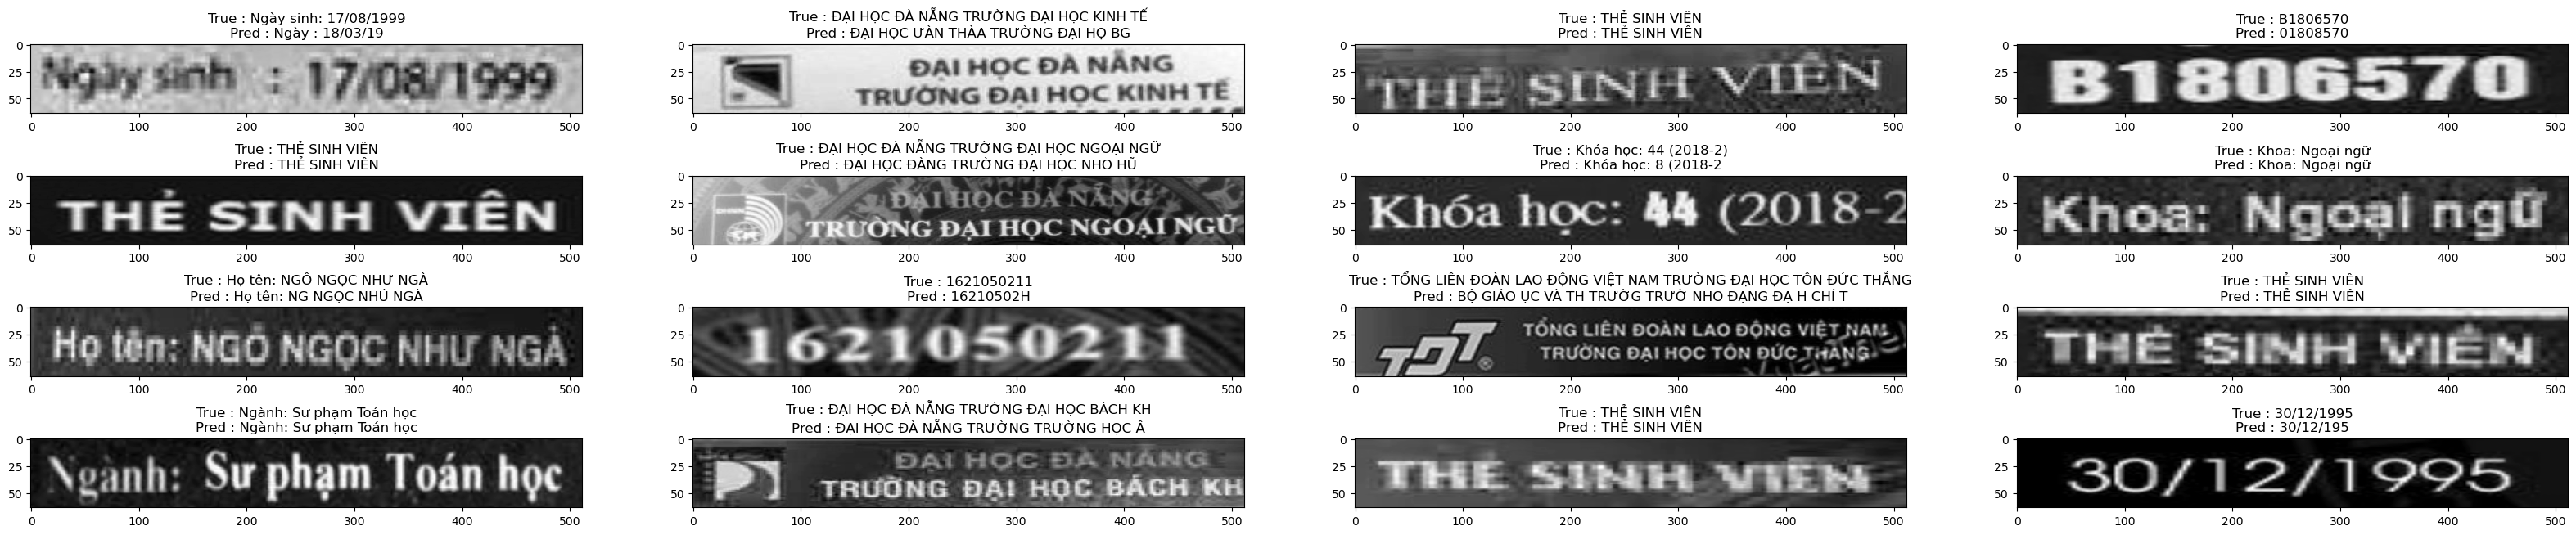

In [25]:
show_images(data=val_ds, model=inference_ocr_model, decode_pred=decode_pred, cmap='binary')

In [26]:
imgs = [np.array(Image.open(x).resize((IMG_WIDTH, IMG_HEIGHT))) for x in mapping_label.keys()]

50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 401ms/step


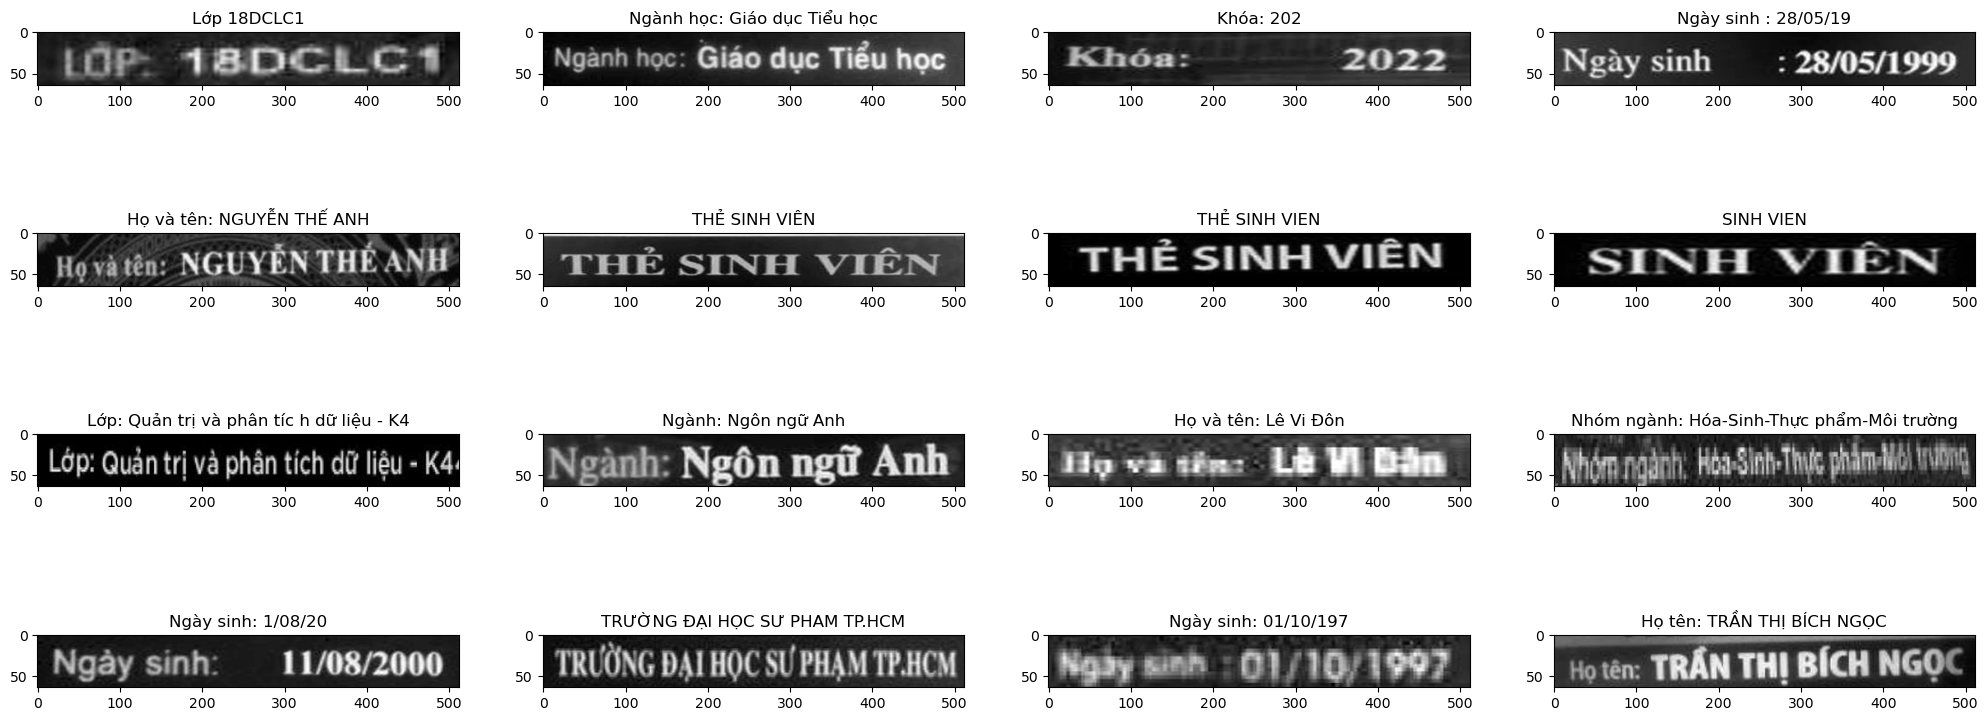

In [30]:
def decode_pred_r(pred_label):

    input_len = np.ones(shape=pred_label.shape[0]) * pred_label.shape[1]


    decode = tf.keras.backend.ctc_decode(pred_label, input_length=input_len, greedy=False, beam_width=10)[0][0]
    chars = num_to_char(decode)

    texts = [tf.strings.reduce_join(inputs=char).numpy().decode('UTF-8') for char in chars]
    # 
    filtered_texts = [text.replace('[UNK]', " ").strip() for text in texts]
    # 
    return filtered_texts
def ocr(images):
    image_tf = tf.expand_dims(images, -1)
    image_tf = (image_tf/255)
    image_tf = tf.transpose(image_tf, (0, 2, 1, 3))
    pred = inference_ocr_model.predict(image_tf)
    texts = decode_pred_r(pred)
    i = 1
    plt.figure(figsize=(25, 10))
    for text, img in zip(texts, images):
        plt.subplot(4, 4, i)
        plt.imshow(img, cmap='binary')
        plt.title(text)
        if i == 16: break
        i += 1
      
    return texts  
texts = ocr(imgs)

In [31]:
len(texts)

1588

In [29]:
ocr_model.save("./ocr_model.h5")
ocr_model.load_weights("./ocr_model.h5")

In [31]:
inference_ocr_model.save("inference_ocr_model.h5")

In [36]:
list(dict_labels.keys())[-1]

'data_4646.png'

In [35]:
i = 3059
for text in texts:
    dict_labels[f"data_{i}.png"] = text
    i += 1

In [37]:
with open("./textcls.json", 'w', encoding="utf-8") as f:
    f.write(json.dumps(dict_labels))